In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
watch=lambda: gdspy.LayoutViewer(depth=0,pattern={'default': 8},background='#FFFFFF') #this opens a viewer

In [3]:
tl_core = 20.
tl_gap = 12.
tl_ground = 10.

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [4]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

# 2. Create main copler:

main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                            (coupler_start+coupler_length, central_line_y)],
                                   [resonator_core, resonator_ground, tl_core],[resonator_gap, resonator_gap, tl_gap, tl_gap],
                                   tl_ground, sample.layer_configuration, r=100)
sample.add(main_coupler)

# 3. Create fanout to create closed enfd of resonator
fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

# 4. 
g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=10, grounding_between = [(2,3)])

# 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])

# 6. Create closed meander of resonator
closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                            meander_length=2300,restricted_scale=400, constant_scale=900, radius=0)

# 7. Create fanout to create closed enfd of resonator
fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

# 8. 
g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

# 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

# 10. Create closed meander of resonator
open_end_resonator = elements.CPW(name='open end resonator', points=[fanout_for_open_end.get_terminals()['down'].position, (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                                                                    fanout_for_open_end.get_terminals()['down'].position[1]-1000)],
                                  w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                  g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
sample.add(open_end_resonator)
sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator, 'port1', 0)))

# 11. Create grounding of resonator
resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])

In [6]:
sample.connections

[((CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 0),
  (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 0)),
 ((CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 1),
  (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 1)),
 ((CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 2),
  (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 2)),
 ((RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'center', 0),
  (RectGrounding cl1, 'wide', 0)),
 ((RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'center', 1),
  (RectGrounding cl1, 'wide', 1)),
 ((CPW "left TL", l=968.634, 'port1', 0),
  (<QCreator.elements.pad.Pad at 0x7f457577a9e8>, 'port', 0)),
 ((CPW "left TL", l=968.634, 'port2', 0), (RectGrounding cl1, 'narrow', 0)),
 ((CPW "closed end", l=2299.958, 'port1', 0),
  (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'up', 0)),
 ((CPWCoupler "TL-resonator coupl

In [47]:
sample.objects

 CPWCoupler "TL-resonator coupler", n=3, l=299.798,
 RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
 RectGrounding cl1,
 CPW "left TL", l=968.634,
 CPW "closed end", l=2299.958,
 RectFanout open end resonator fanout, n=3, grouping=(1, 3),
 RectGrounding cl2,
 CPW "right TL", l=6367.932,
 CPW "open end resonator", l=999.933,
 RectGrounding resonator ground]

In [12]:
design = sample.draw_design()
watch()

/home/alena/anaconda3/lib/python3.7/site-packages/gdspy/path.py:828: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  "[GDSPY] Possible inconsistency found in "
/home/alena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: [GDSPY] Use of the global library is deprecated.  Pass LayoutViewer a GdsLibrary instance.
  """Entry point for launching an IPython kernel.


<gdspy.viewer.LayoutViewer object .!layoutviewer>

In [49]:
gdspy.write_gds('1qubit.gds', cells=None, name='library', unit=1e-06, precision=1e-09, timestamp=None, binary_cells=None)

In [50]:
resonator_ground

16

In [13]:
sys, connections, elements_ = sample.get_tls()

In [14]:
f, delta, modes = sys.get_modes()
f/(2*np.pi), delta

(array([8.01217031e+09, 8.20320246e+09, 1.63715129e+10, 2.47542955e+10,
        2.51928373e+10, 3.21080071e+10, 3.26067433e+10, 3.29754968e+10,
        3.44920595e+10, 3.73061474e+10, 3.76129873e+10, 4.10496715e+10,
        4.24384604e+10, 4.24957520e+10, 4.26787727e+10, 4.32672739e+10,
        4.33808811e+10, 5.74085959e+10, 6.13051858e+10, 7.42055462e+10,
        9.00811841e+10, 9.38815941e+10, 1.01720792e+11, 1.12216757e+11,
        1.16723268e+11, 1.16898041e+11, 1.18113397e+11, 1.18334581e+11,
        1.19562521e+11, 1.19664503e+11, 1.20188988e+11, 1.20271187e+11,
        1.40350562e+11, 1.40798831e+11, 1.81443006e+11, 1.82835257e+11,
        2.18628732e+11, 2.25209742e+11, 2.42436523e+11, 2.45505952e+11,
        2.46898992e+11, 2.48510892e+11, 2.61118813e+11, 2.67631124e+11,
        2.67948440e+11, 2.73494687e+11, 2.73780940e+11, 2.73943175e+11,
        2.74359408e+11, 2.77526758e+11, 2.78185230e+11, 2.78823458e+11,
        2.79557098e+11, 2.82163234e+11, 2.83434804e+11, 2.845002

In [52]:
sys.terminal_node_mapping

[[6],
 [14],
 [1, 2, 3, 9, 10, 11],
 [1, 2, 4, 5],
 [3, 8],
 [5, 0],
 [4, 7],
 [6, 7],
 [8, 17],
 [11, 16],
 [10, 9, 12, 13],
 [12, 0],
 [13, 15],
 [14, 15],
 [16, 18],
 [17]]

In [8]:
connections

{(CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 0): 1,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 0): 1,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 1): 2,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 1): 2,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  0): 4,
 (RectGrounding cl1, 'wide', 0): 4,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  1): 5,
 (RectGrounding cl1, 'wide', 1): 5,
 (CPW "left TL", l=968.634, 'port1', 0): 6,
 (<QCreator.elements.pad.Pad at 0x7f457577a9e8>, 'port', 0): 6,
 (CPW "left TL", l=968.634, 'port2', 0): 7,
 (RectGrounding cl1, 'narrow', 0): 7,
 (CPW "closed end", l=2299.958, 'port1', 0): 8,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'up', 0): 8,

In [6]:
elements_

{'chip_edge_ground': [],
 'p1': [Port p1],
 'p2': [Port p2],
 'TL-resonator coupler': [TL TL-resonator coupler (n=3)],
 'closed end resonator fanout': [TL closed end resonator fanout_group1 (n=2),
  TL closed end resonator fanout_group2 (n=1)],
 'cl1': [[R cl10, TL cl1 (n=1)]],
 'left TL': [TL left TL (n=1)],
 'closed end': [TL closed end (n=1)],
 'open end resonator fanout': [TL open end resonator fanout_group0 (n=1),
  TL open end resonator fanout_group1 (n=2)],
 'cl2': [[R cl20, TL cl2 (n=1)]],
 'right TL': [TL right TL (n=1)],
 'open end resonator': [TL open end resonator (n=1)],
 'resonator ground': [Short ]}

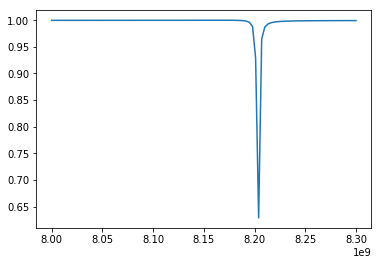

In [18]:
f = np.linspace(8e9, 8.3e9, 101)
#s11 = sample.get_s21('p1', 'p1', f)
s21 = sample.get_s21('p1', 'p2', f)
from matplotlib import pyplot as plt
#plt.plot(f, np.abs(s11))
plt.plot(f, np.abs(s21))

In [57]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f/(2*np.pi), delta

(array([8.01217031e+09, 8.20320246e+09, 1.63715129e+10, 2.47542955e+10,
        2.51928373e+10, 3.21080074e+10, 3.26067431e+10, 3.29754970e+10,
        3.44920594e+10, 3.73061474e+10, 3.76129874e+10, 4.10496715e+10,
        4.24384604e+10, 4.24957520e+10, 4.26787733e+10, 4.32672738e+10,
        4.33808811e+10, 5.74085959e+10, 6.13051852e+10, 7.42055462e+10,
        9.00811842e+10, 9.38815943e+10, 1.01720791e+11, 1.12216757e+11,
        1.16723272e+11, 1.16898045e+11, 1.18113393e+11, 1.18334577e+11,
        1.19562526e+11, 1.19664508e+11, 1.20188983e+11, 1.20271182e+11,
        1.40350562e+11, 1.40798831e+11, 1.81443006e+11, 1.82835257e+11,
        2.18628736e+11, 2.25209742e+11, 2.42436524e+11, 2.45505952e+11,
        2.46898992e+11, 2.48510894e+11, 2.61118812e+11, 2.67631129e+11,
        2.67948451e+11, 2.73494674e+11, 2.73780942e+11, 2.73943167e+11,
        2.74359398e+11, 2.77526768e+11, 2.78185227e+11, 2.78823458e+11,
        2.79557098e+11, 2.82163234e+11, 2.83434804e+11, 2.845002